In [1]:
from mne import read_epochs, set_eeg_reference
from mne.decoding import CSP, UnsupervisedSpatialFilter
from mne.preprocessing import ICA, EOGRegression
import numpy as np
from mne.viz import plot_ica_components
from jupyterthemes.stylefx import set_nb_theme
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
set_nb_theme('gruvboxd')

Load and Preprocessing

In [3]:
import sys
sys.path.append('../../preprocessing')
from load_data import load_raw_to_epochs, get_channel_types

# load_raw_to_epochs('nhm.bdf', True)

In [4]:
raw = read_epochs('raw_epo.fif')

Reading C:\Users\Alberto\Documents\BCI\data\nhm\raw_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated


Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1528 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 6928 tasks      | elapsed:    7.6s
[Parallel(n_jobs=8)]: Done 7488 out of 7488 | elapsed:    8.0s finished


Using matplotlib as 2D backend.


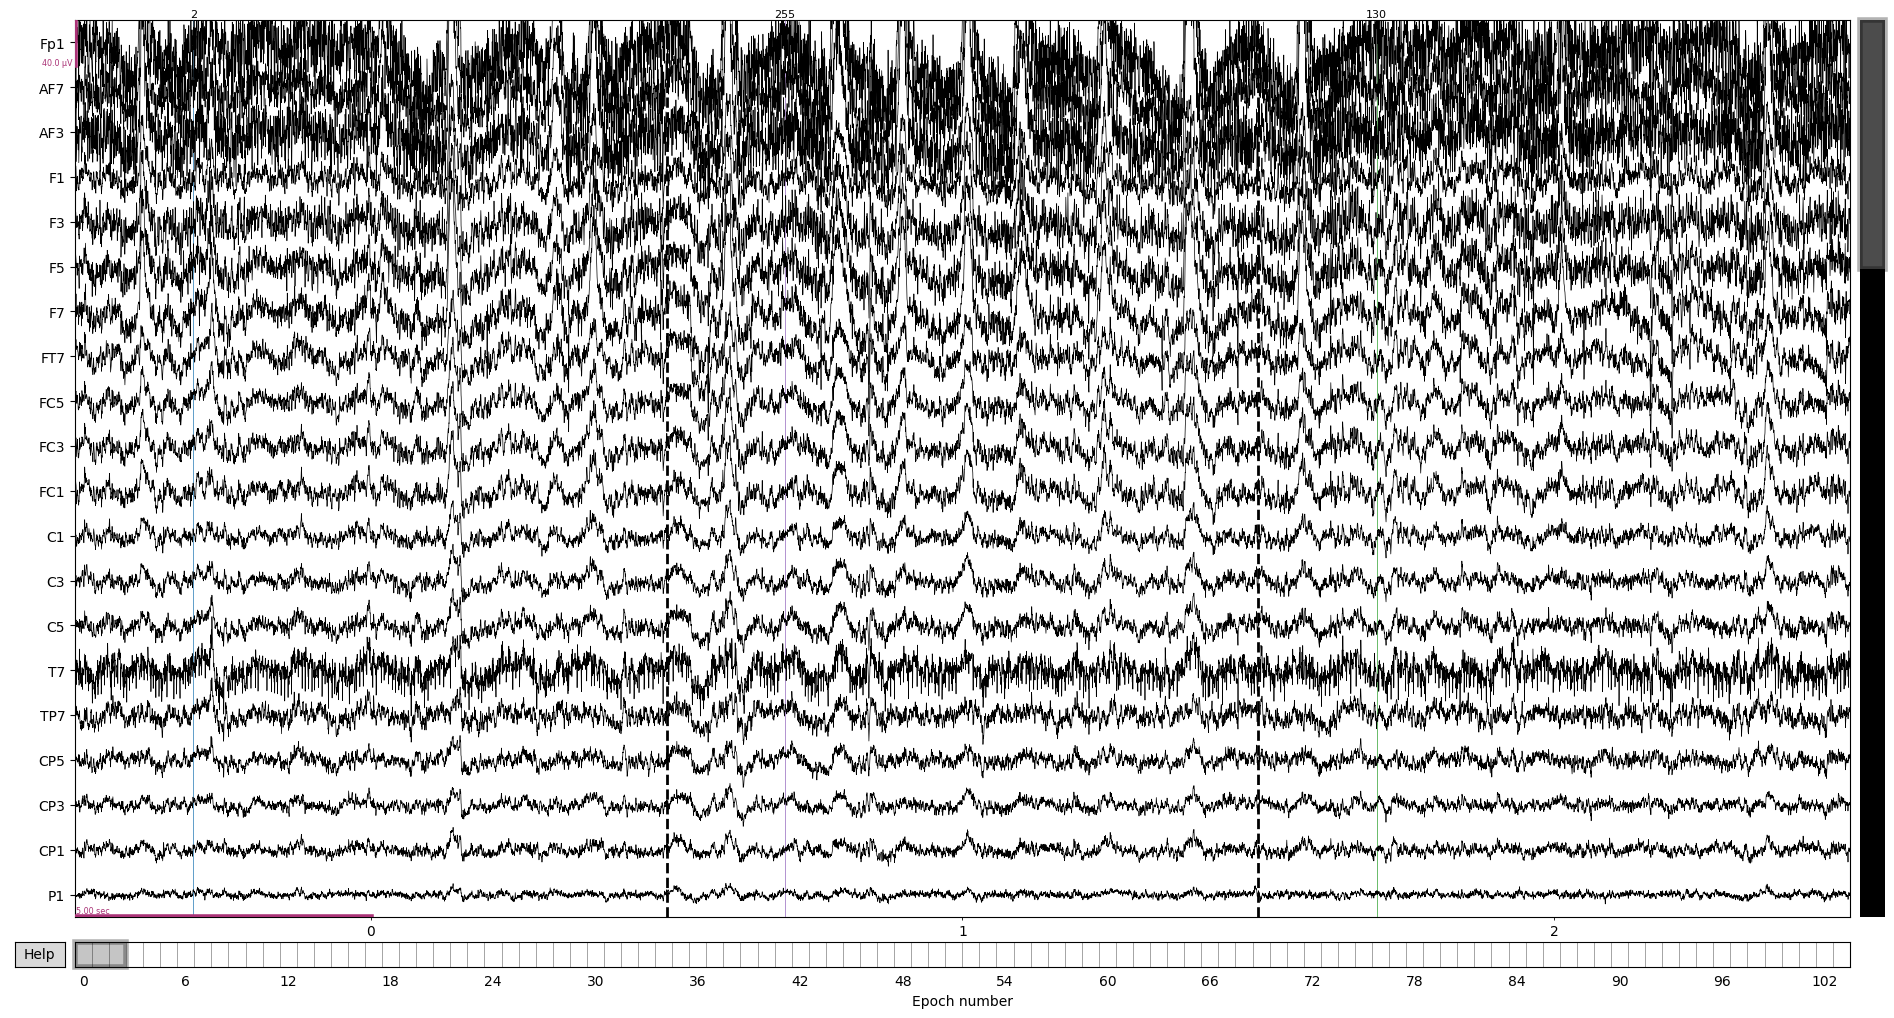

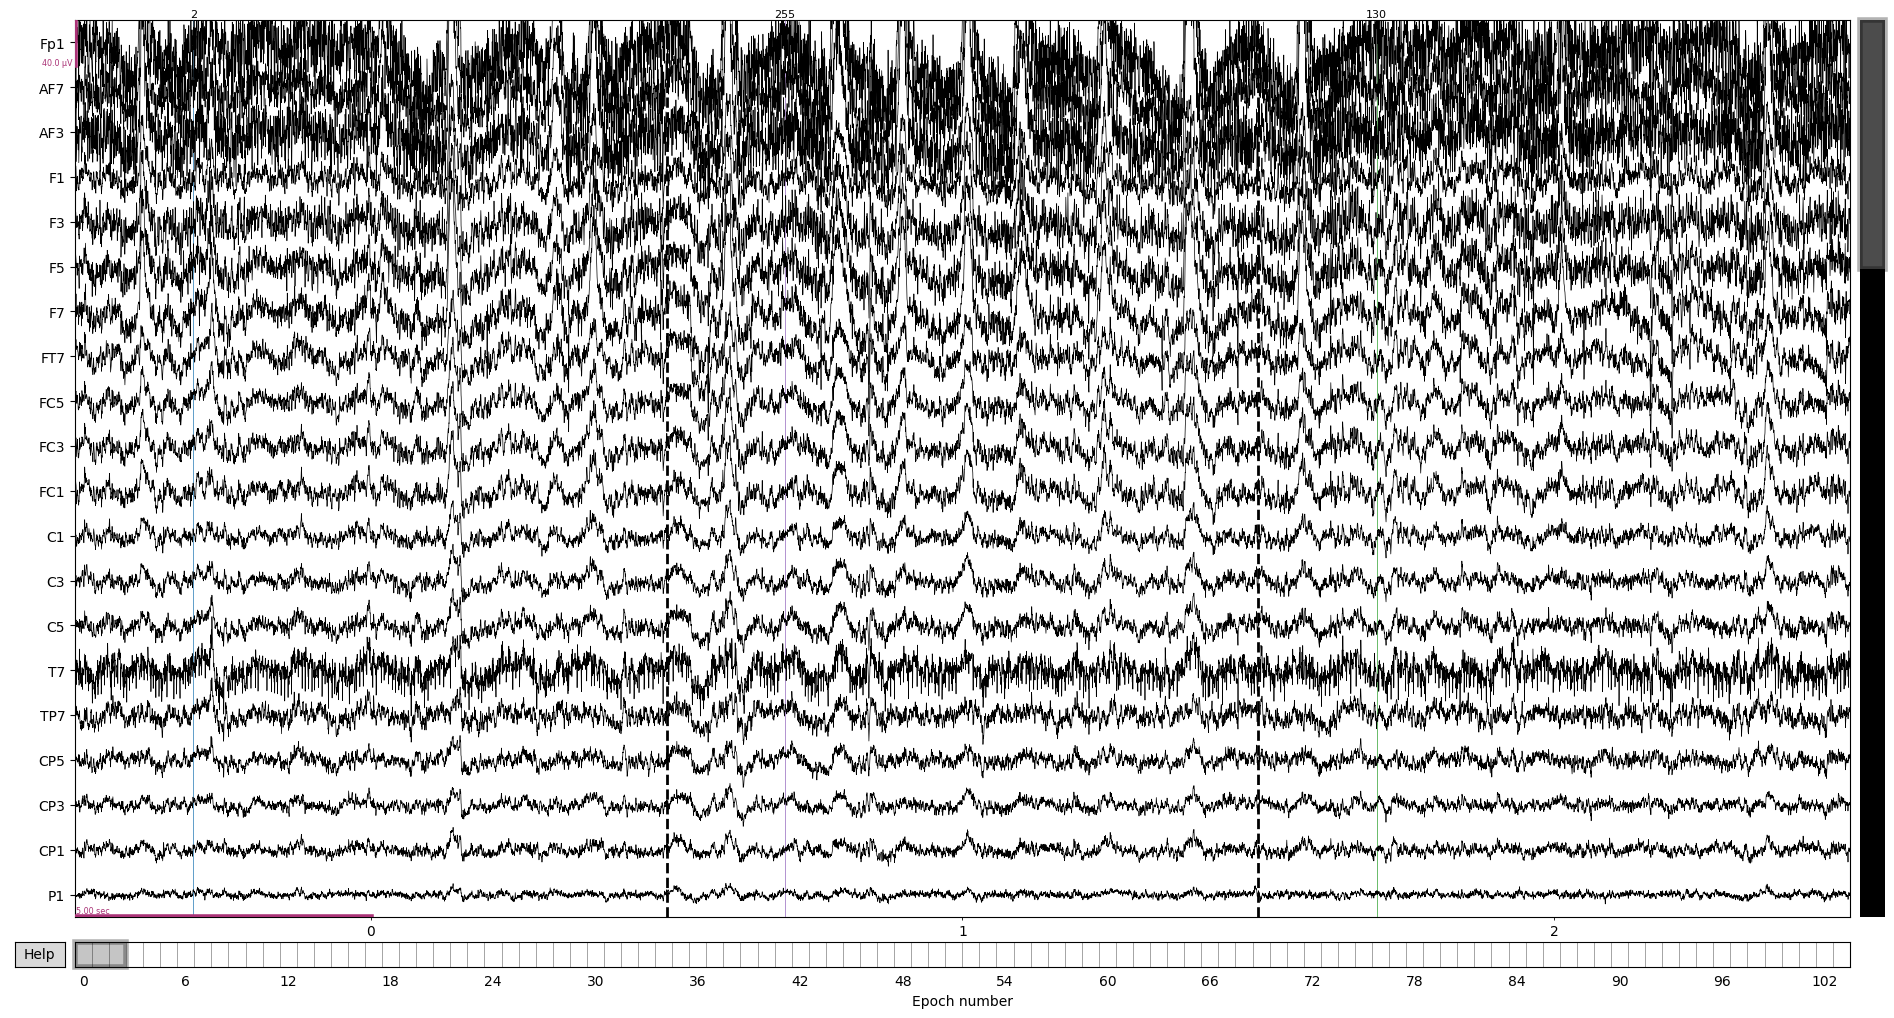

In [5]:
raw.copy().filter(1,120, n_jobs=8).plot(n_channels=20, n_epochs=3, scalings=20e-6, events=raw.events)

Marking bad chanels

In [5]:
bads = ['EXG7', 'O2', 'AF4', 'AFz', 'POz', 'EXG5']
raw.info['bads'] = bads
raw.drop([5, 14, 18, 42, 43, 68, 77, 83, 95, 108, 110])

Dropped 11 epochs: 5, 14, 18, 42, 43, 68, 77, 83, 95, 108, 110


<EpochsFIF |  105 events (all good), -2 - 7.99902 sec, baseline off, ~598.9 MB, data loaded,
 'r_pinch': 20
 'r_stop': 22
 'left': 22
 'right': 24
 'rest': 17>

Referencing

In [6]:
referenced = set_eeg_reference(raw,ref_channels='average')[0]
del raw

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


set channel types

In [7]:
referenced.set_channel_types(get_channel_types())

<EpochsFIF |  105 events (all good), -2 - 7.99902 sec, baseline off, ~598.9 MB, data loaded,
 'r_pinch': 20
 'r_stop': 22
 'left': 22
 'right': 24
 'rest': 17>

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done 5000 tasks      | elapsed:    9.4s
[Parallel(n_jobs=8)]: Done 6720 out of 6720 | elapsed:   11.4s finished


Using matplotlib as 2D backend.


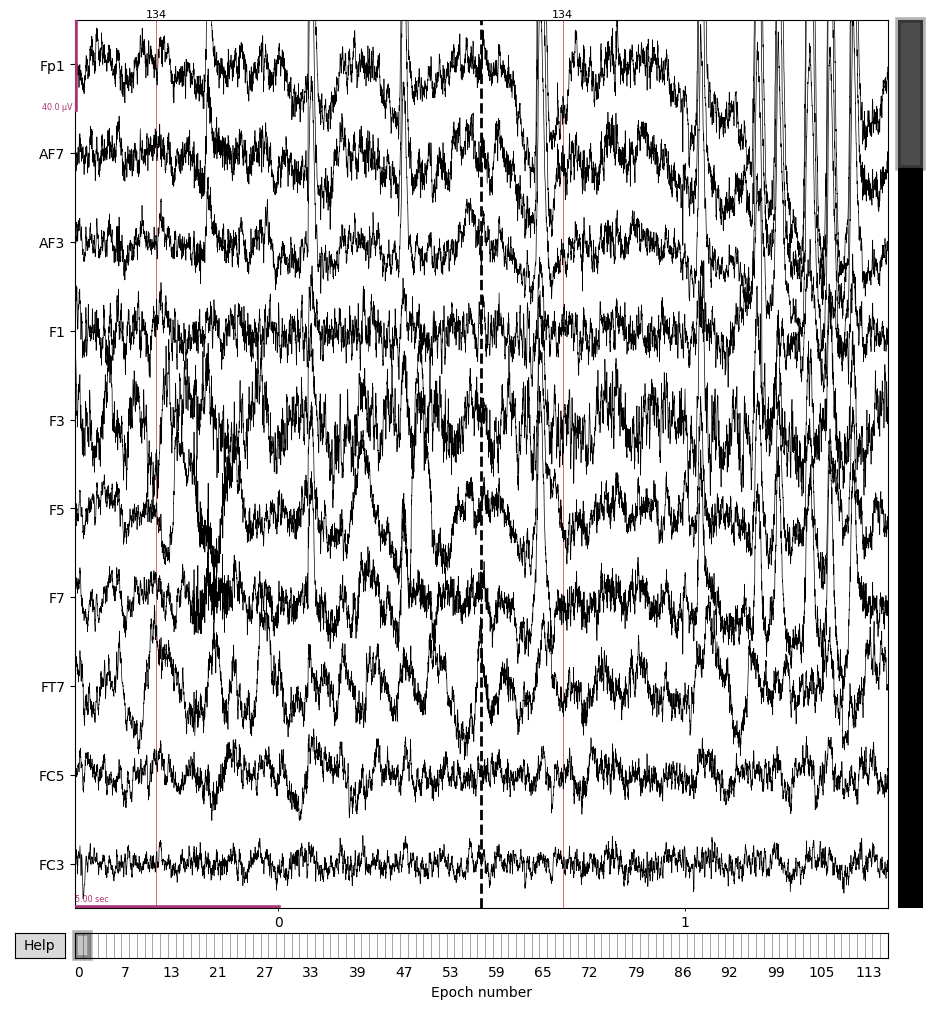

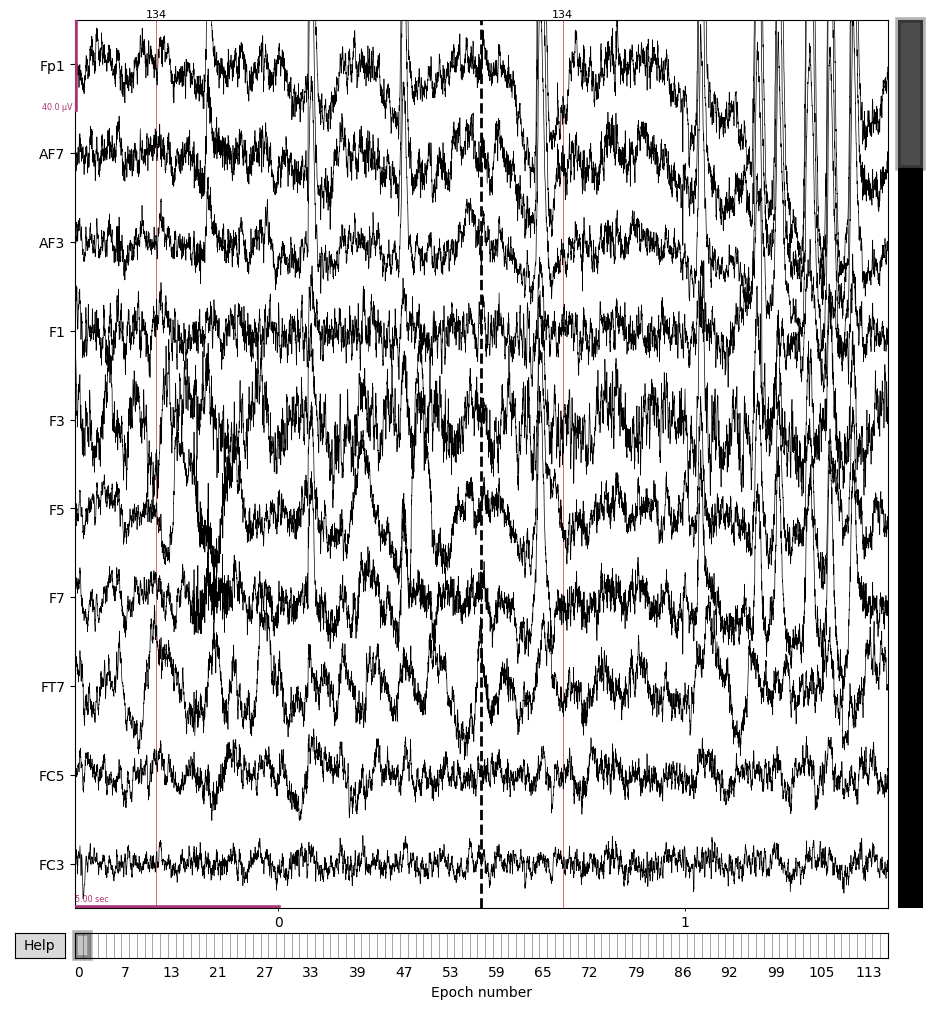

In [8]:
referenced.copy().filter(1,120, n_jobs=8).plot(n_channels=10, n_epochs=2, scalings=20e-6, events=referenced.events, picks=['eeg','ecg'])

EOG Regression


No projector specified for this dataset. Please consider the method self.add_proj.


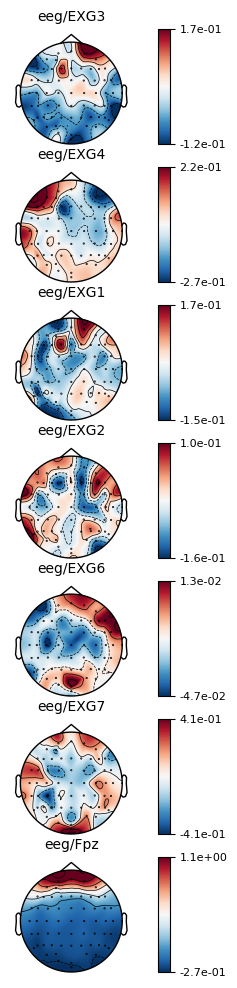

No projector specified for this dataset. Please consider the method self.add_proj.


In [9]:
print()
emg_eog = ['EXG3','EXG4','EXG1','EXG2','EXG6','EXG7','Fpz']
regressor = EOGRegression(
    picks='eeg', picks_artifact= emg_eog).fit(referenced)
regressor.plot()
referenced = regressor.apply(referenced)
referenced.info['bads'] += ['Fpz']

In [10]:
referenced.save('referenced_epo.fif', overwrite=True)
del referenced

Overwriting existing file.


REMOVE ARTIFACTS


In [11]:
epochs = read_epochs('referenced_epo.fif')

Reading C:\Users\Alberto\Documents\BCI\data\nhm\referenced_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\Alberto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


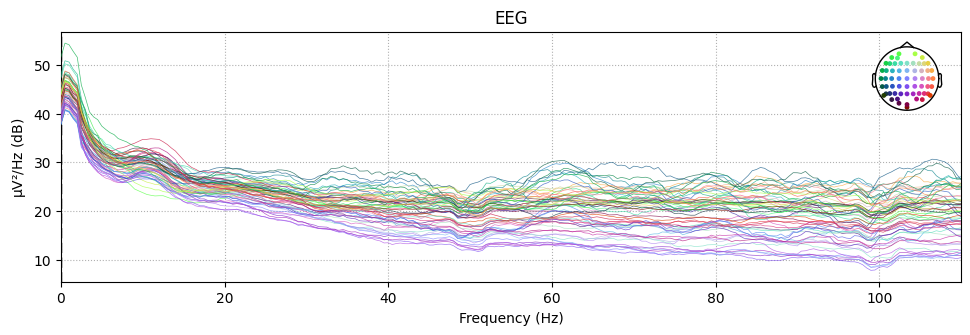

In [12]:
epochs['right','left'].copy().crop(-1,2).plot_psd(fmax=110, tmin=0, tmax=4)

ICA

In [15]:
filtered = epochs['rest','left','right'].copy().filter(1,120, n_jobs=8)
filtered.apply_baseline((-1.2,-0.1))
filtered.crop(-0.5,1.5)
ica = ICA(n_components=12, method='picard')
ica.fit(filtered)

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1528 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 3866 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 4032 out of 4032 | elapsed:    3.7s finished


Applying baseline correction (mode: mean)
Fitting ICA to data using 59 channels (please be patient, this may take a while)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_9600\2633140768.py:5: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(filtered)


Selecting by number: 12 components
Fitting ICA took 8.6s.


<ICA | epochs decomposition, method: picard (fit in 71 iterations on 129087 samples), 12 ICA components (59 PCA components available), channel types: eeg, no sources marked for exclusion>

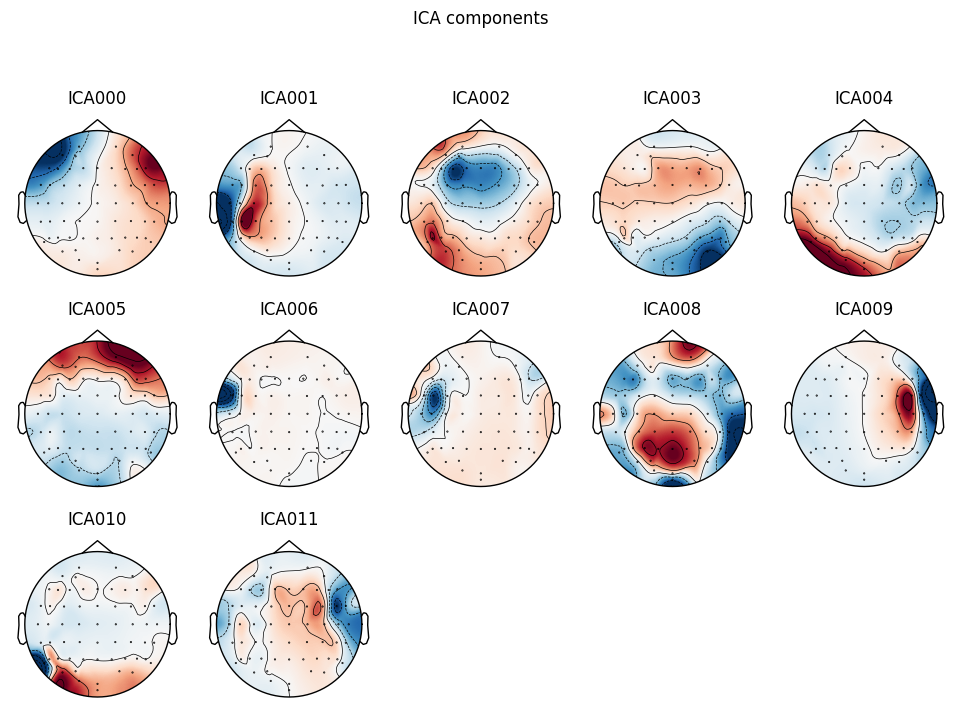

[<MNEFigure size 975x731.5 with 12 Axes>]

In [16]:
print()
plot_ica_components(ica)

C:\Users\Alberto\AppData\Local\Temp\ipykernel_9600\1990462223.py:2: RuntimeWarning: filter_length (3381) is longer than the signal (1946), distortion is likely. Reduce filter length or filter a longer signal.
  epochs['left','right'].copy().crop(-0.1,1.8).filter(1,120, verbose=False),


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
46 matching events found
No baseline correction applied
0 projection i

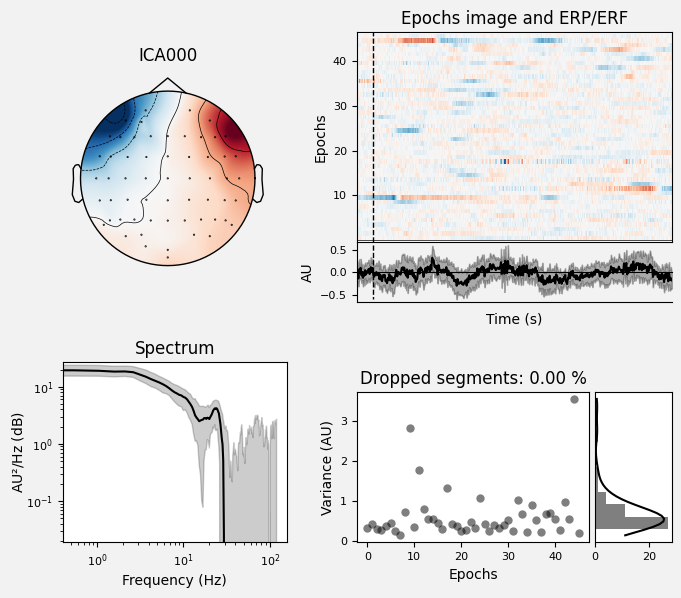

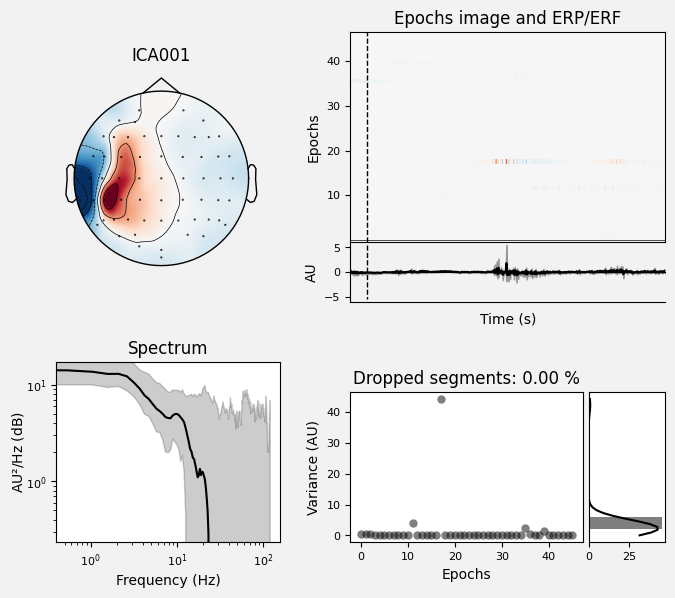

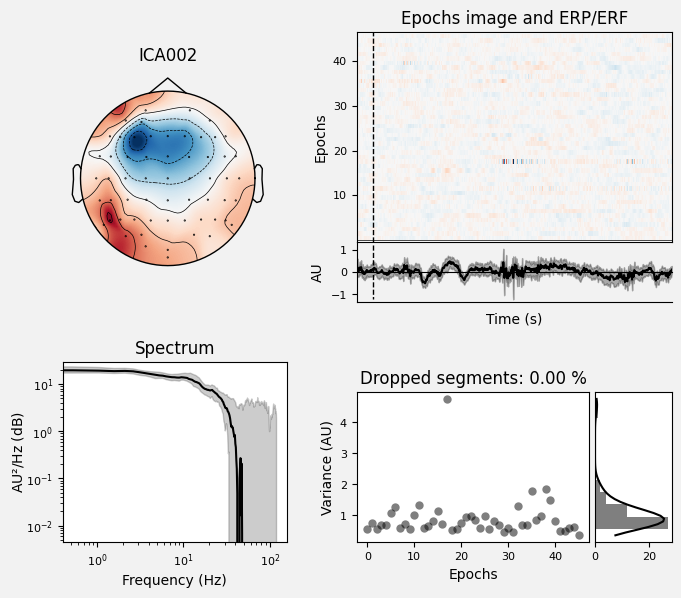

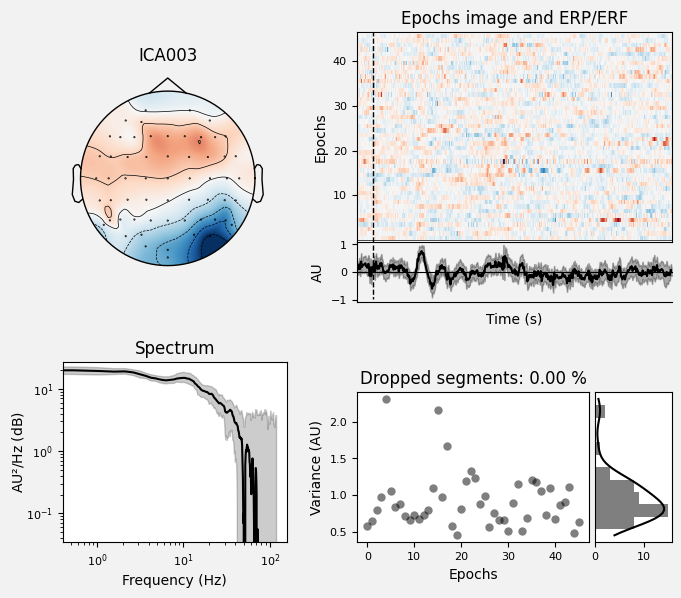

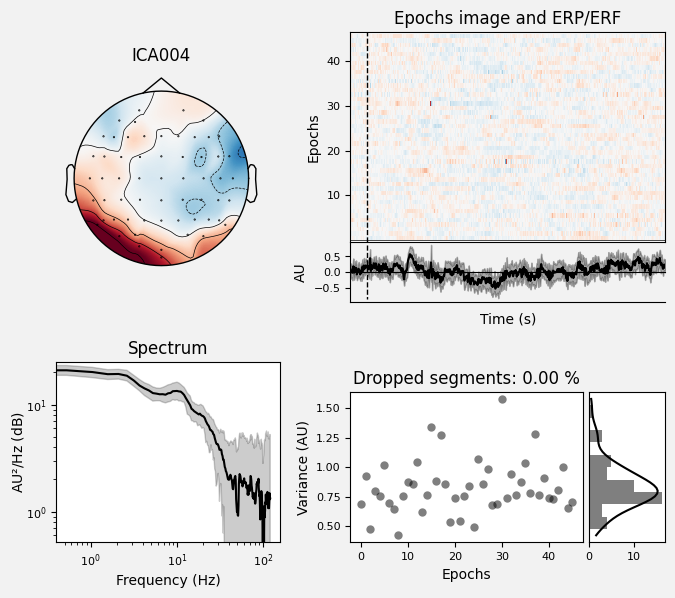

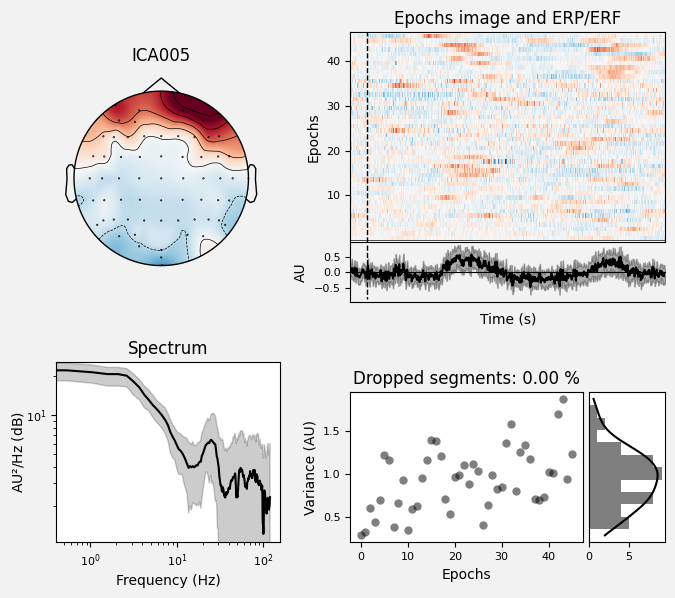

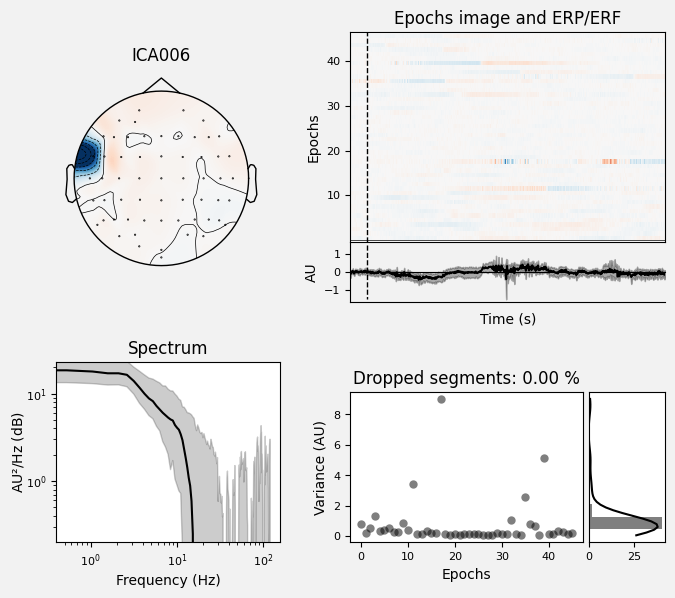

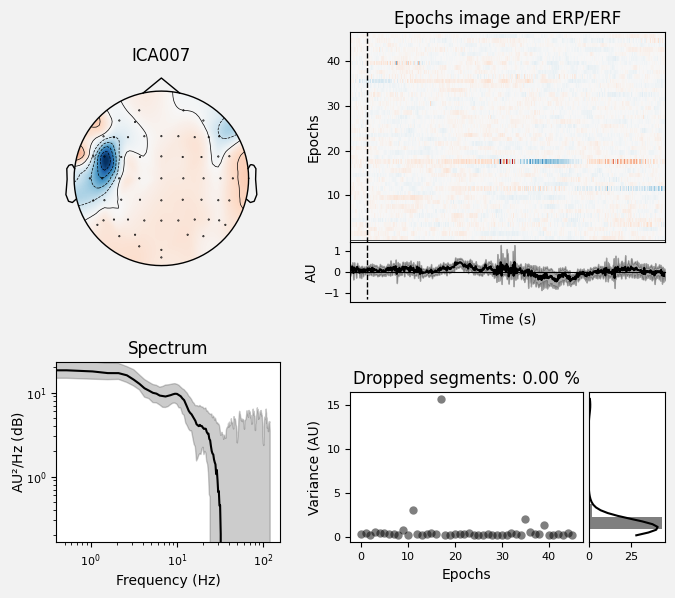

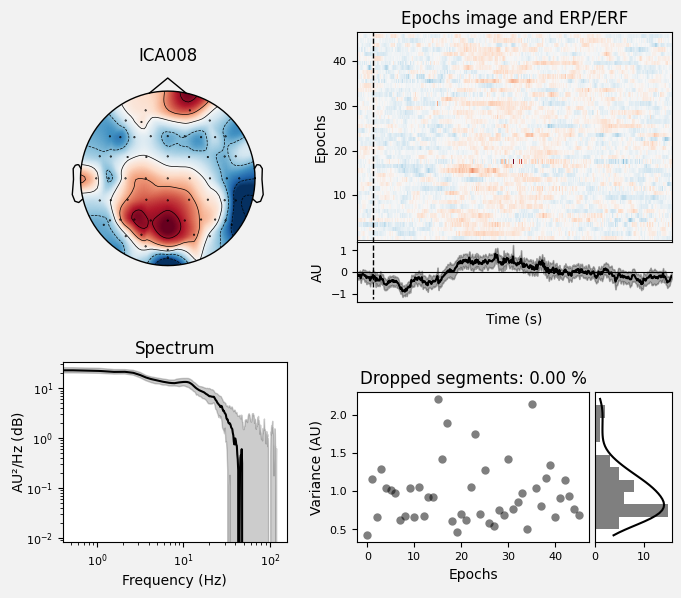

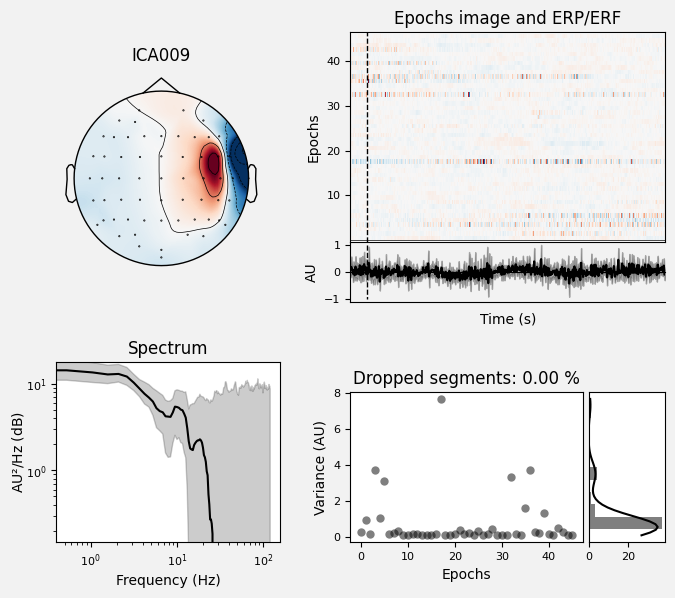

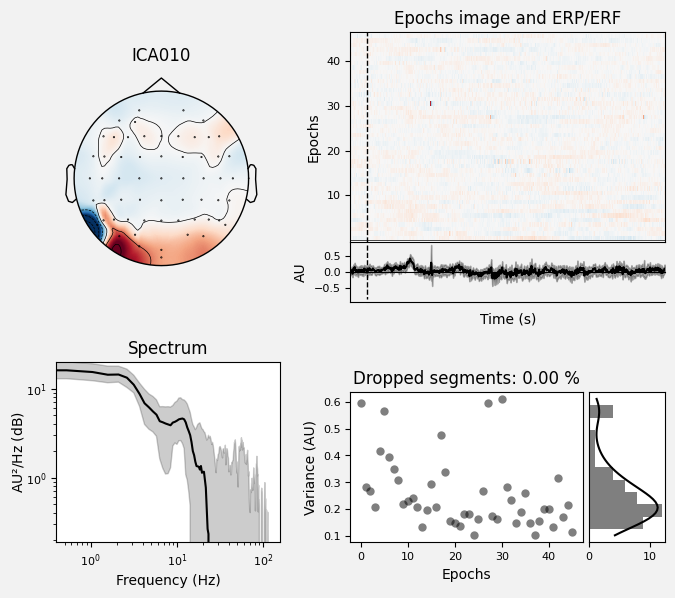

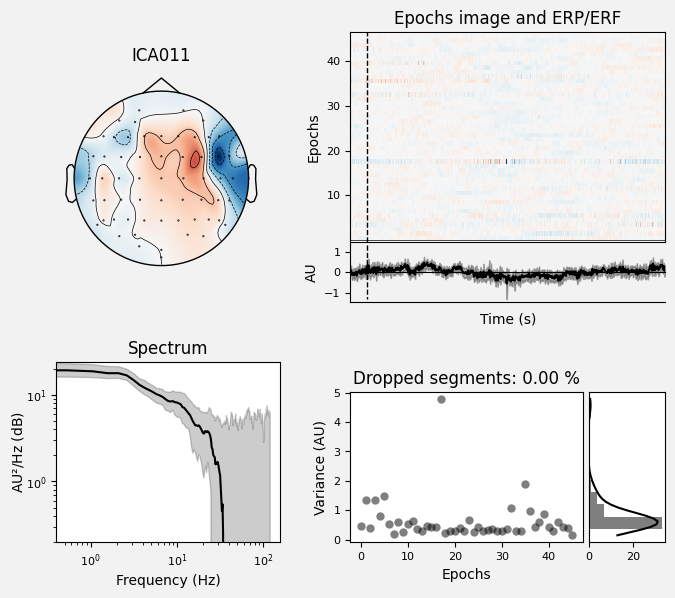

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [18]:
ica.plot_properties(
    epochs['left','right'].copy().crop(-0.1,1.8).filter(1,120, verbose=False), 
    picks = [0,1,2,3,4,5,6,7,8,9,10,11], 
    log_scale = True,
    psd_args = dict(fmax=120))

In [36]:
eog_indices, eog_scores = ica.find_bads_eog(
    filtered['left','right','rest'],
    ch_name= emg_eog, 
    measure='zscore',
    threshold=2)


Using EOG channels: EXG3, EXG4, EXG1, EXG2, EXG6, EXG7, Fpz


In [37]:
eog_indices


[3, 4, 5]

In [19]:
ica.apply(epochs, exclude=np.unique([0,1,5,6,9,10,11]))

Applying ICA to Epochs instance
    Transforming to ICA space (12 components)
    Zeroing out 7 ICA components
    Projecting back using 59 PCA components


<EpochsFIF |  105 events (all good), -2 - 7.99902 sec, baseline off, ~598.9 MB, data loaded,
 'r_pinch': 20
 'r_stop': 22
 'left': 22
 'right': 24
 'rest': 17>

ERP

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



C:\Users\Alberto\AppData\Local\Temp\ipykernel_9600\1697825411.py:1: RuntimeWarning: filter_length (3381) is longer than the signal (3073), distortion is likely. Reduce filter length or filter a longer signal.
  epochs['left','right'].copy().crop(-1,2).filter(1,120, n_jobs=8).average().plot()
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1689 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 2944 out of 2944 | elapsed:    1.1s finished


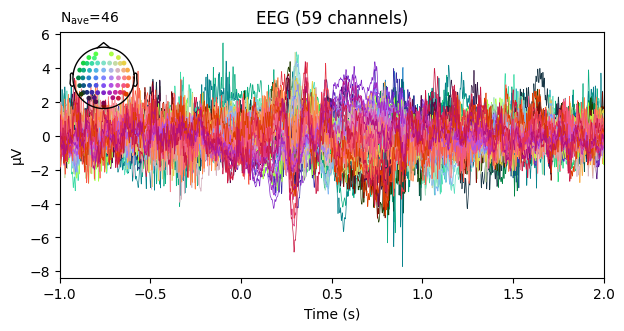

In [20]:
epochs['left','right'].copy().crop(-1,2).filter(1,120, n_jobs=8).average().plot()
print()

Setting up band-pass filter from 2 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 1691 samples (1.651 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1024 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1088 out of 1088 | elapsed:    0.3s finished


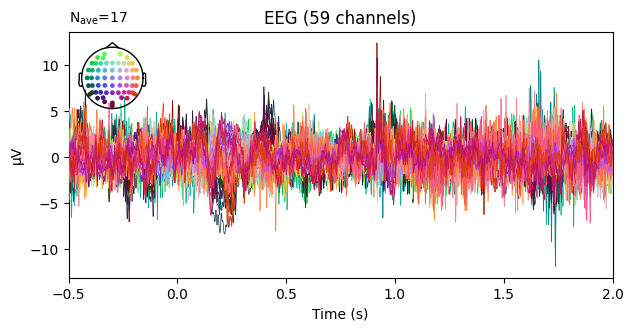

In [21]:
epochs['rest'].copy().crop(-0.5,2).filter(2,120, n_jobs=8).average().plot()
print()

CSP

In [46]:
le = LabelEncoder()
subset = epochs['left','rest'].copy()
subset.apply_baseline((-1.,-0.1))
subset.drop_channels(epochs.info['bads'])
subset = subset.pick(['eeg'])
y = le.fit_transform(subset.events[:,2])

Applying baseline correction (mode: mean)


In [47]:
pca = UnsupervisedSpatialFilter(PCA(len(subset.info['chs'])), average=False)
csp = CSP(n_components=2, reg=None, log=True, norm_trace=False, rank='info')
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(5, 20, n_jobs=4, verbose=False).get_data(),y)

Computing rank from data with rank='info'
    MAG: rank 59 after 0 projectors applied to 59 channels
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 59 after 0 projectors applied to 59 channels
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.


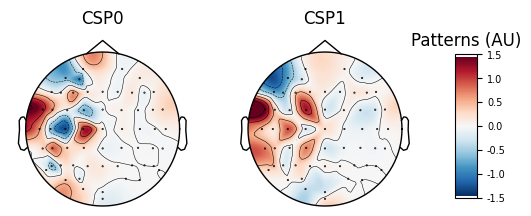

In [48]:
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(5, 20, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

Computing rank from data with rank='info'
    MAG: rank 59 after 0 projectors applied to 59 channels
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 59 after 0 projectors applied to 59 channels
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.


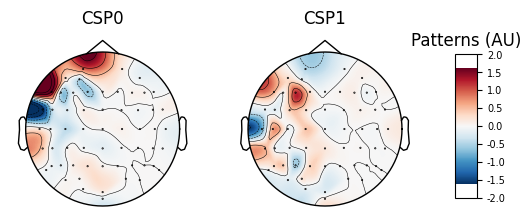

In [49]:
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(20, 35, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

Computing rank from data with rank='info'
    MAG: rank 59 after 0 projectors applied to 59 channels
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 59 after 0 projectors applied to 59 channels
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.


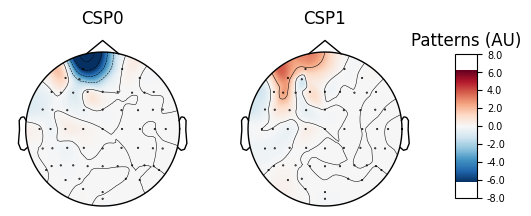

In [50]:
x = pca.fit_transform(subset.copy().crop(-0.1,1.8).filter(70, 90, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

In [22]:
epochs.save('ica_epo.fif', overwrite=True)

Overwriting existing file.


In [23]:
epochs

<EpochsFIF |  105 events (all good), -2 - 7.99902 sec, baseline off, ~598.9 MB, data loaded,
 'r_pinch': 20
 'r_stop': 22
 'left': 22
 'right': 24
 'rest': 17>